In [16]:
%load_ext autoreload
%autoreload 2

import os
import h5py
import pickle

import numpy as np
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline
plt.style.use('/mnt/home/tnguyen/default.mplstyle')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
# save the halo properties to a file
cat_path = "/mnt/ceph/users/tnguyen/dark_camels/point-cloud-diffusion-datasets/fof_catalogs/"\
    "mw_zooms-wdm.pkl"
with open(cat_path, 'rb') as f:
    halo_props = pickle.load(f)

snap_num = 90
min_halo_count = 20
out_dataset_dir = "/mnt/ceph/users/tnguyen/dark_camels/point-cloud-diffusion-datasets"
out_dataset_name = "wdm-min{0}-snap{1}".format(min_halo_count, snap_num)

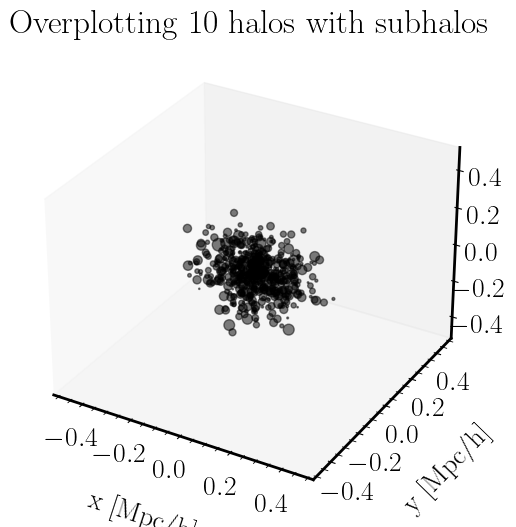

In [20]:
# plot the 3D positions of the subhalos
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

for halo_idx in range(10):
    pos = halo_props['pos'][halo_idx]
    vel = halo_props['vel'][halo_idx]
    mass = halo_props['mass'][halo_idx]
    subhalo_count = halo_props['subhalo_count'][halo_idx]
    subhalo_mass = halo_props['subhalo_mass'][halo_idx]
    subhalo_pos = halo_props['subhalo_pos'][halo_idx]
    subhalo_vel = halo_props['subhalo_vel'][halo_idx]
    subhalo_pos = subhalo_pos - pos
    subhalo_vel = subhalo_vel - vel

    # get the normalized subhalo mass
    # normalize to [0, 1] range 
    s = np.log10(subhalo_mass)
    s = (s - s.min()) / (s.max() - s.min()) * 100
    ax.scatter(
        subhalo_pos[:, 0], subhalo_pos[:, 1], subhalo_pos[:, 2],
        s=s, c='k', alpha=0.5)

ax.set_xlabel('x [Mpc/h]', labelpad=20)
ax.set_ylabel('y [Mpc/h]', labelpad=20)
ax.set_zlabel('z [Mpc/h]', labelpad=20)
ax.set_title('Overplotting 10 halos with subhalos')

# aspect ratio of the plot
max_range = 0.5
ax.set_xlim(-max_range, max_range)
ax.set_ylim(-max_range, max_range)
ax.set_zlim(-max_range, max_range)
ax.grid(False)
plt.show()

In [31]:
# create numpyz dataset for the subhalos
num_halos = len(halo_props['pos'])

x = []
conditioning_dict = {
    'log_mass': [],
    'wdm_mass': [],
}

for halo_idx in range(num_halos):
    pos = halo_props['pos'][halo_idx]
    vel = halo_props['vel'][halo_idx]
    mass = halo_props['mass'][halo_idx]
    sobol_params = halo_props['sobol_params'][halo_idx]
    subhalo_count = halo_props['subhalo_count'][halo_idx]
    subhalo_mass = halo_props['subhalo_mass'][halo_idx]
    subhalo_pos = halo_props['subhalo_pos'][halo_idx]
    subhalo_vel = halo_props['subhalo_vel'][halo_idx]
    subhalo_pos = subhalo_pos - pos
    subhalo_vel = subhalo_vel - vel

    # remove the first subhalo (the central subhalo)
    subhalo_pos = subhalo_pos[1:, :]
    subhalo_vel = subhalo_vel[1:, :]
    subhalo_mass = subhalo_mass[1:]

    # sort the subhalos by descending mass
    idx = np.argsort(subhalo_mass)[::-1]
    subhalo_pos = subhalo_pos[idx, :]
    subhalo_vel = subhalo_vel[idx, :]
    subhalo_mass = subhalo_mass[idx]

    if len(subhalo_mass) < min_halo_count:
        continue


    # only keep the first 100 subhalos
    feat = np.concatenate(
        [subhalo_pos, subhalo_vel, subhalo_mass.reshape(-1, 1)], axis=1)
    feat = feat[:min_halo_count, :]
    x.append(feat)

    # conditioning dict
    conditioning_dict['log_mass'].append(np.log10(mass))
    conditioning_dict['wdm_mass'].append(sobol_params[0])

x = np.stack(x, axis=0)
conditioning_dict['log_mass'] = np.array(conditioning_dict['log_mass'])
conditioning_dict['wdm_mass'] = np.array(conditioning_dict['wdm_mass'])

In [36]:
# split the data into train and test
train_frac = 0.8
num_halos = len(x)
num_train = int(train_frac * num_halos)
num_test = num_halos - num_train

# shuffle the data and conditioning dict
shuffle = np.random.permutation(num_halos)
x = x[shuffle, :, :]
conditioning_dict['log_mass'] = conditioning_dict['log_mass'][shuffle]

x_train = x[:num_train, :, :]
conditioning_dict_train = {
    'log_mass': conditioning_dict['log_mass'][:num_train],
    'wdm_mass': conditioning_dict['wdm_mass'][:num_train]
}
out_train_path = os.path.join(out_dataset_dir, out_dataset_name + "_train.npy")
jnp.save(out_train_path, x_train)

# save the conditioning dict as CSV file
df_train = pd.DataFrame(conditioning_dict_train)
df_train.to_csv(os.path.join(
    out_dataset_dir, out_dataset_name + "_conditioning_train.csv"))